In [1]:
from IPython.display import clear_output# load Mask R-CNN code implementation
!git clone https://github.com/ruslan-kl/brain-tumor.git # load new data set and annotations 
!pip install pycocotools
!git clone https://github.com/leekunhee/Mask_RCNN.git
# !rm -rf brain-tumor/.git/
# !rm -rf Mask_RCNN/.git/

# clear_output()

Cloning into 'brain-tumor'...
remote: Enumerating objects: 263, done.
remote: Counting objects: 100% (263/263), done.
remote: Compressing objects: 100% (256/256), done.
remote: Total 263 (delta 6), reused 263 (delta 6), pack-reused 0
Receiving objects: 100% (263/263), 6.79 MiB | 9.57 MiB/s, done.
Resolving deltas: 100% (6/6), done.
  Using cached Cython-0.29.22-cp38-cp38-macosx_10_9_x86_64.whl (1.9 MB)
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp38-cp38-macosx_10_9_x86_64.whl size=89323 sha256=0b30b198c7dcd92567d8029e8d32866bd70741b8e8e168969b40e6000ac11cfb
  Stored in directory: /Users/i516344/Library/Caches/pip/wheels/e7/77/b2/6f38b5bea571cd8f4689f91a7c1ed2eaecb2c2ce17f9945b17
Successfully built pycocotools
Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 983, done.
remote: Total 983 (delta 0), reused 0 (delta 0), pack-reused 983
Receiving objects: 100% (983/983), 136.81 MiB | 8.14 MiB/s, done.
Resolving deltas: 100% (577/577), done.


In [32]:
!pip3 install imgaug
!pip install seaborn

     |████████████████████████████████| 285 kB 4.1 MB/s eta 0:00:01


In [5]:
import os 
import sys
from tqdm import tqdm
import cv2
import shutil
import numpy as np
import json
import skimage.draw
import matplotlib
import matplotlib.pyplot as plt
import random

# Root directory of the project
ROOT_DIR = os.path.abspath('Mask_RCNN/')
# Import Mask RCNN
sys.path.append(ROOT_DIR) 
from mrcnn.config import Config
from mrcnn import utils
from mrcnn.model import log
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, 'samples/coco/'))
import coco

plt.rcParams['figure.facecolor'] = 'white'


In [6]:
def get_ax(rows=1, cols=1, size=7):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [7]:
MODEL_DIR = os.path.join(ROOT_DIR, 'logs') # directory to save logs and trained model
# ANNOTATIONS_DIR = 'brain-tumor/data/new/annotations/' # directory with annotations for train/val sets
DATASET_DIR = 'brain-tumor/data_cleaned/' # directory with image data
DEFAULT_LOGS_DIR = 'logs' 

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


In [8]:
class TumorConfig(Config):
    """Configuration for training on the brain tumor dataset.
    """
    # Give the configuration a recognizable name
    NAME = 'tumor_detector'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1  # background + tumor
    DETECTION_MIN_CONFIDENCE = 0.85    
    STEPS_PER_EPOCH = 100
    LEARNING_RATE = 0.001
    
config = TumorConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.85
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

In [9]:
class BrainScanDataset(utils.Dataset):

    def load_brain_scan(self, dataset_dir, subset):
        """Load a subset of the FarmCow dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("tumor", 1, "tumor")

        # Train or validation dataset?
        assert subset in ["train", "val", 'test']
        dataset_dir = os.path.join(dataset_dir, subset)

        annotations = json.load(open(os.path.join(DATASET_DIR, subset, 'annotations_'+subset+'.json')))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']]

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "tumor",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, 
                height=height,
                polygons=polygons
            )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a farm_cow dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "tumor":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "tumor":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [10]:
model = modellib.MaskRCNN(
    mode='training', 
    config=config, 
    model_dir=DEFAULT_LOGS_DIR
)

model.load_weights(
    COCO_MODEL_PATH, 
    by_name=True, 
    exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"]
)

In [11]:
# Training dataset.
dataset_train = BrainScanDataset()
dataset_train.load_brain_scan(DATASET_DIR, 'train')
dataset_train.prepare()

# Validation dataset
dataset_val = BrainScanDataset()
dataset_val.load_brain_scan(DATASET_DIR, 'val')
dataset_val.prepare()

dataset_test = BrainScanDataset()
dataset_test.load_brain_scan(DATASET_DIR, 'test')
dataset_test.prepare()

# Since we're using a very small dataset, and starting from
# COCO trained weights, we don't need to train too long. Also,
# no need to train all layers, just the heads should do it.
print("Training network heads")


Training network heads


In [14]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(
    mode="inference", 
    config=config,
    model_dir=DEFAULT_LOGS_DIR
)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
# model_path = model.find_last()

# Load trained weights
print("Loading weights from ", './model/mask_rcnn_tumor_detector_0015.h5')
model.load_weights('./model/mask_rcnn_tumor_detector_0015.h5', by_name=True)

Loading weights from  ./model/mask_rcnn_tumor_detector_0015.h5


In [15]:
# img = dataset_val.load_image(6)
# visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], ['BG', 'T'], r['scores'])
from matplotlib.patches import Rectangle
!pip install pillow
from PIL import ImageDraw, ImageFont
def draw_image_with_boxes(filename, boxes_list, scores):
     # load the image
    data = filename
    fig, ax = plt.subplots()
    ax.imshow(data)

    # plot each box
    i = 0
    for box in boxes_list:
        # get coordinates
        y1, x1, y2, x2 = box
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        rect = Rectangle((x1, y1), width, height, fill=False, color='red', lw=1)
        # draw the box
        ax.add_patch(rect)
        i = i + 1
     # show the plot
    plt.show()

In [16]:
def predict_and_plot_differences(dataset, img_id):
    original_image, image_meta, gt_class_id, gt_box, gt_mask =\
        modellib.load_image_gt(dataset, config, 
                               img_id)

    results = model.detect([original_image], verbose=0)
    r = results[0]
    return r
#     visualize.display_differences(
#         original_image,
#         gt_box, gt_class_id, gt_mask,
#         r['rois'], r['class_ids'], r['scores'], r['masks'],
#         class_names = ['tumor'], title="", ax=get_ax(),
#         show_mask=True, show_box=True)
    

def display_image(dataset, ind):
    plt.figure(figsize=(5,5))
    plt.imshow(dataset.load_image(ind))
    plt.xticks([])
    plt.yticks([])
    plt.title('Original Image')
    plt.show()


In [17]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

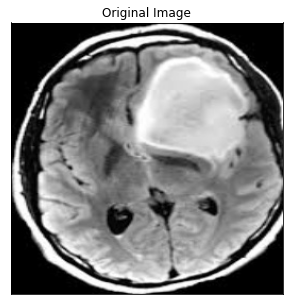

/Users/i516344/.conda/envs/pythonProject/lib/python3.8/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/Users/i516344/.conda/envs/pythonProject/lib/python3.8/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


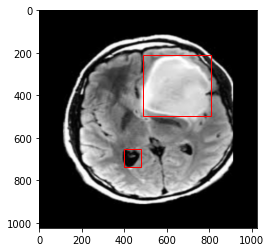

[0.9968972  0.95535976] [[[False False]
  [False False]
  [False False]
  ...
  [False False]
  [False False]
  [False False]]

 [[False False]
  [False False]
  [False False]
  ...
  [False False]
  [False False]
  [False False]]

 [[False False]
  [False False]
  [False False]
  ...
  [False False]
  [False False]
  [False False]]

 ...

 [[False False]
  [False False]
  [False False]
  ...
  [False False]
  [False False]
  [False False]]

 [[False False]
  [False False]
  [False False]
  ...
  [False False]
  [False False]
  [False False]]

 [[False False]
  [False False]
  [False False]
  ...
  [False False]
  [False False]
  [False False]]]


In [43]:

#vALIDATION SET
ind = 1
display_image(dataset_train, ind)
r = predict_and_plot_differences(dataset_train, ind)
original_image, image_meta, gt_class_id, gt_box, gt_mask =\
        modellib.load_image_gt(dataset_train, config, 
                              ind)
draw_image_with_boxes(original_image, r['rois'], r['scores'])
print(r['scores'], r['masks'])

# ind = 6
# display_image(dataset_val, ind)
# r = predict_and_plot_differences(dataset_val, ind)
# original_image, image_meta, gt_class_id, gt_box, gt_mask =\
#         modellib.load_image_gt(dataset_val, config, 
#                               ind)
# draw_image_with_boxes(original_image, r['rois'], r['scores'])
# print(r['scores'])

# #Test Set
# ind = 1
# display_image(dataset_test, ind)
# r = predict_and_plot_differences(dataset_test, ind)
# original_image, image_meta, gt_class_id, gt_box, gt_mask =\
#         modellib.load_image_gt(dataset_test, config, 
#                               ind)
# draw_image_with_boxes(original_image, r['rois'], r['scores'])
# print(r['scores'])

# ind = 0
# display_image(dataset_test, ind)
# r = predict_and_plot_differences(dataset_test, ind)
# original_image, image_meta, gt_class_id, gt_box, gt_mask =\
#         modellib.load_image_gt(dataset_test, config, 
#                               ind)
# draw_image_with_boxes(original_image, r['rois'], r['scores'])
# print(r['scores'])


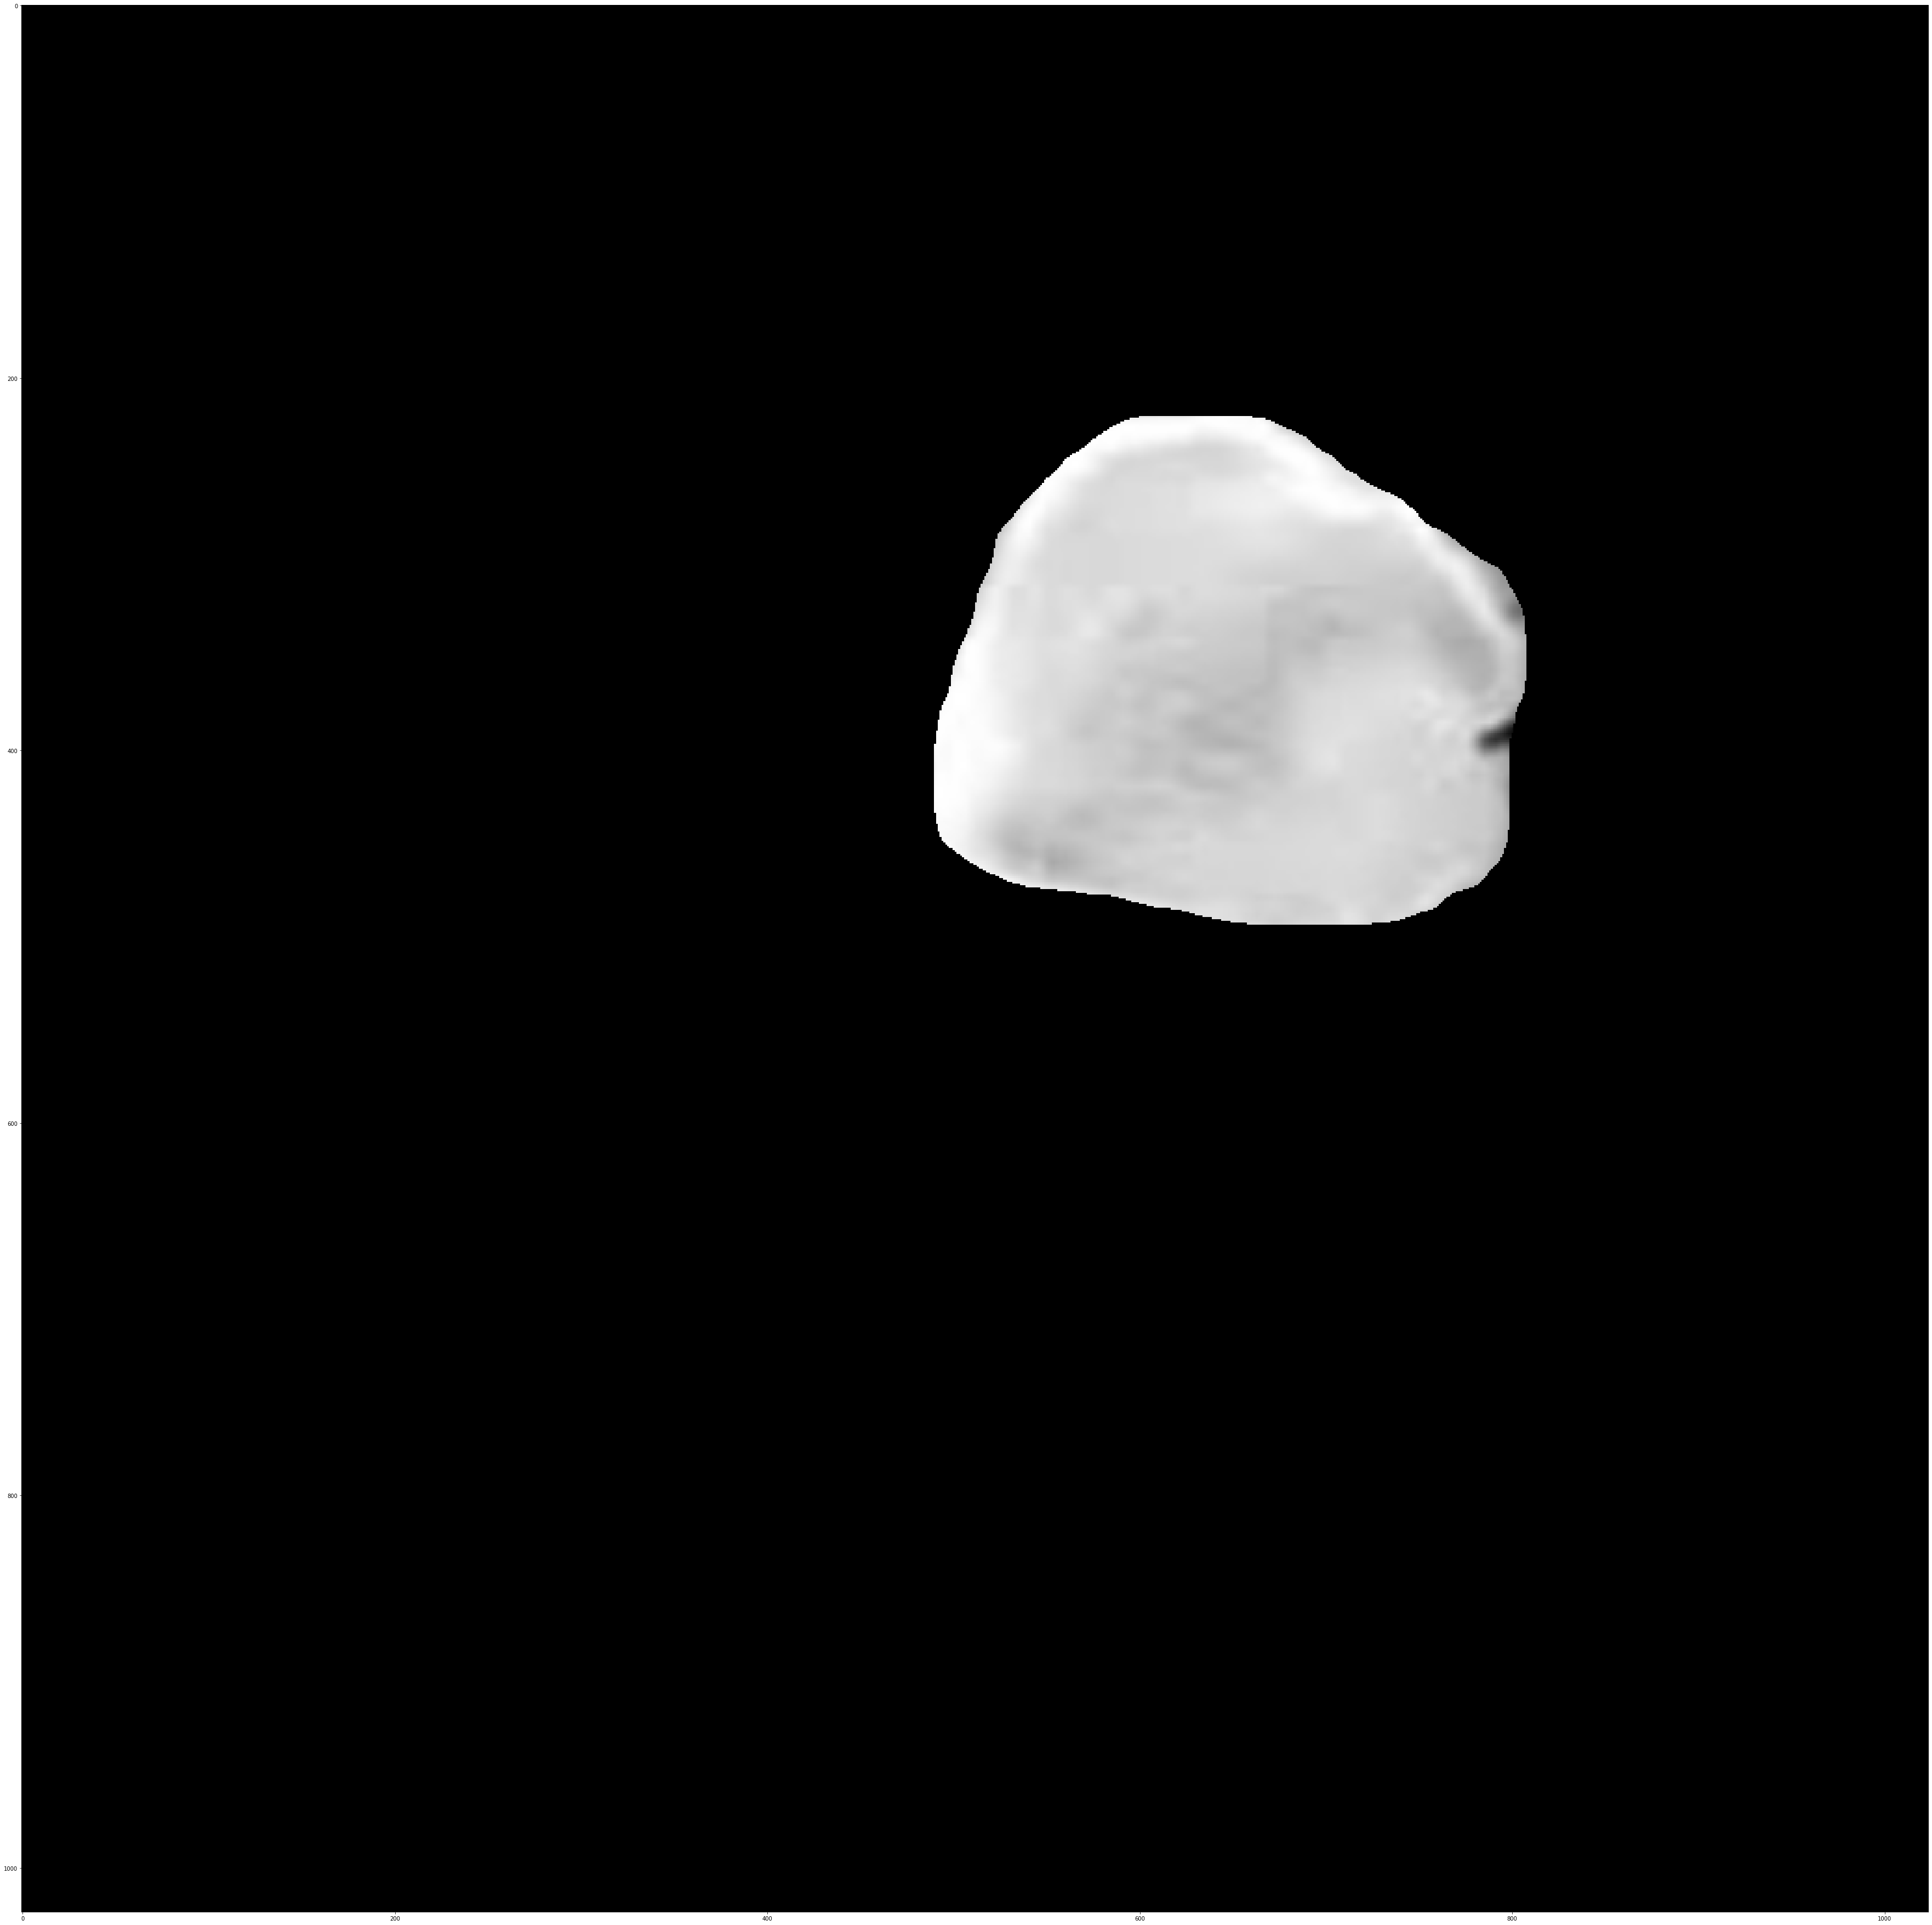

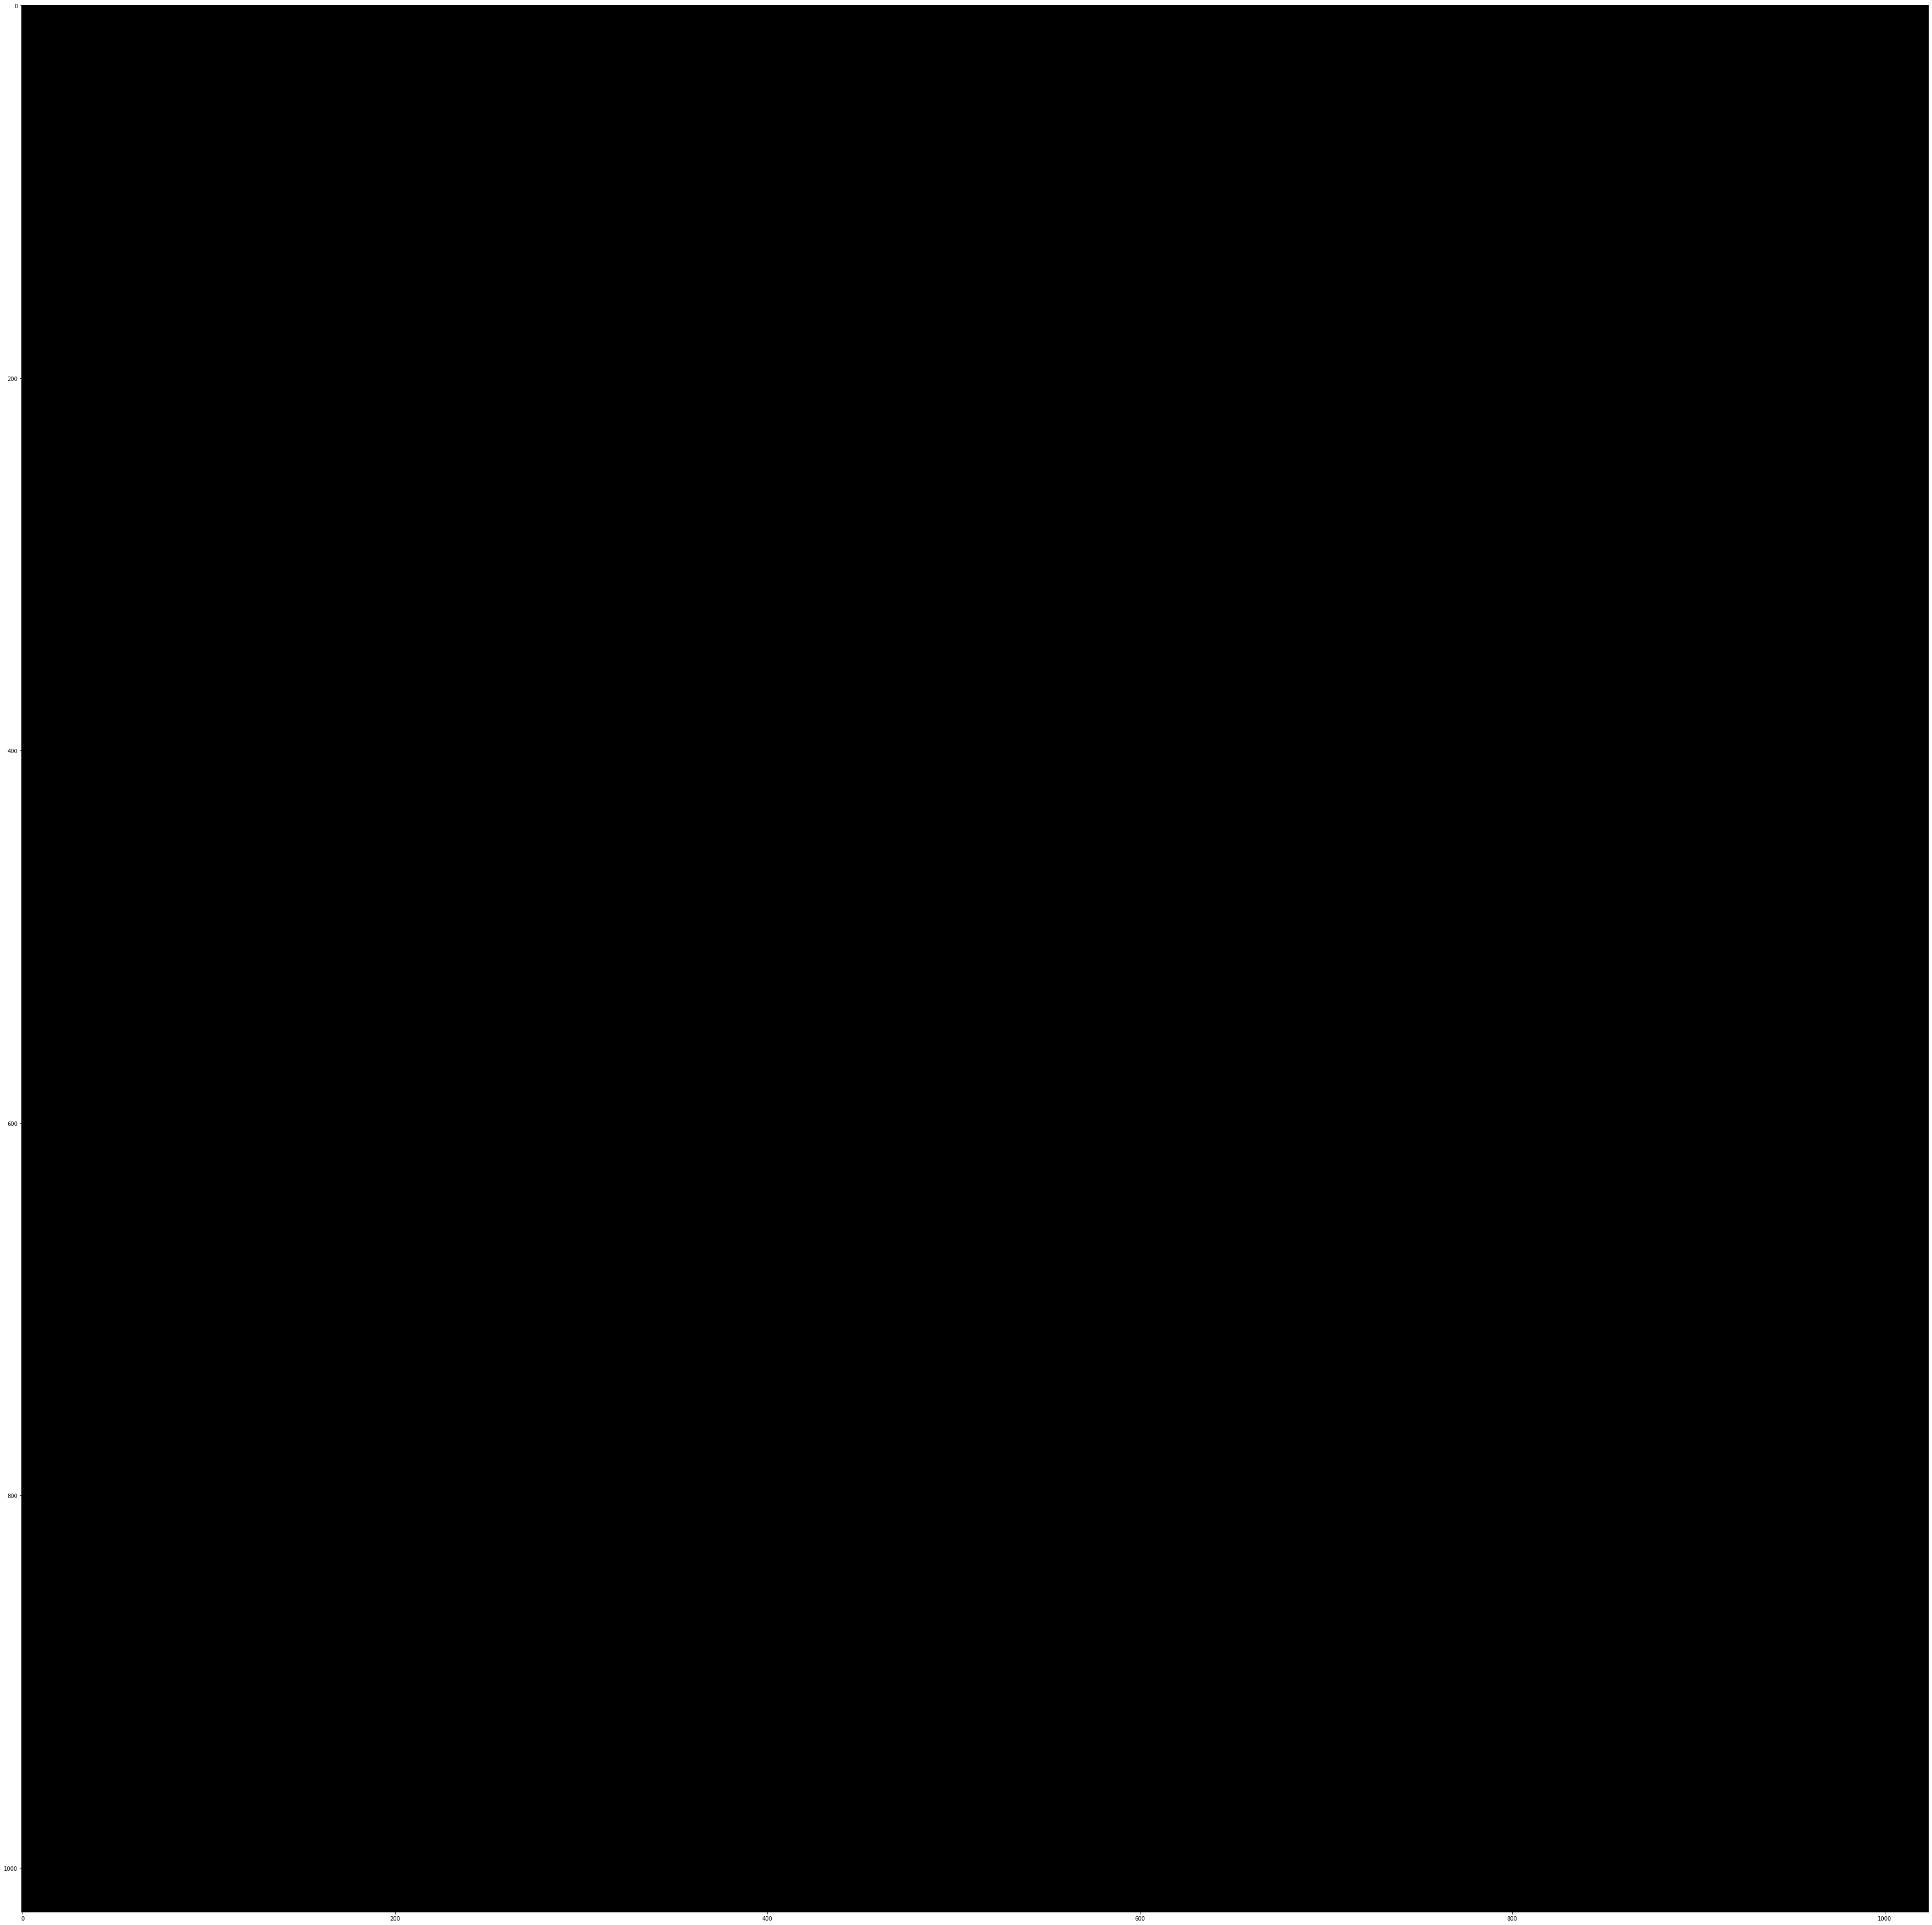

In [47]:
mask = r['masks']
for i in range(mask.shape[2]):
    temp = original_image
    for j in range(temp.shape[2]):
        temp[:,:,j] = temp[:,:,j] * mask[:,:,i]
    plt.figure(figsize=(64, 64))
    plt.imshow(temp)

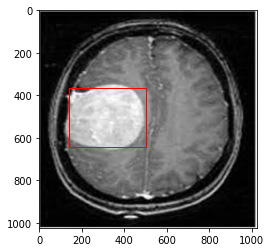

[0.9971457]


In [19]:
imgloc = './model/test1.jpeg'
from PIL import Image
import cv2
img = cv2.imread(imgloc)
res = cv2.resize(img, dsize=(1024, 1024), interpolation=cv2.INTER_CUBIC)
r = model.detect([res], verbose=0)
r = r[0]
draw_image_with_boxes(res, r['rois'], r['scores'])
print(r['scores'])


In [20]:
original_image, image_meta, gt_class_id, gt_box, gt_mask =\
        modellib.load_image_gt(dataset_test, config, 
                              ind)
original_image.shape


/Users/i516344/.conda/envs/pythonProject/lib/python3.8/site-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


(1024, 1024, 3)

In [21]:
import pandas as pd
patients_data = pd.DataFrame()
patients_data['patient_id'] = []
patients_data['image'] = []

In [22]:
val_images = os.listdir('./brain-tumor/data/val')


In [23]:
images_tumor = []
for image in val_images:
    if len(image) == 8:
        images_tumor.append('./brain-tumor/data/val/' + image)

In [24]:
patient_ids = [1,2,3,4,5,6,7,8,9,10]

In [25]:
for i in patient_ids:
    img = np.random.choice(images_tumor, 5, replace=False)
    for image in img:
        patients_data.loc[len(patients_data.index)] = [i, image] 

In [26]:
patients_data['num_of_tumor'] = [None]*50
patients_data['size'] = [None]*50
patients_data['probability'] = [None]*50

In [27]:
patients_data

,patient_id,image,num_of_tumor,size,probability
0,1.0,./brain-tumor/data/val/Y194.jpg,None,None,None
1,1.0,./brain-tumor/data/val/Y252.jpg,None,None,None
2,1.0,./brain-tumor/data/val/Y257.jpg,None,None,None
3,1.0,./brain-tumor/data/val/Y181.jpg,None,None,None
4,1.0,./brain-tumor/data/val/Y188.jpg,None,None,None
5,2.0,./brain-tumor/data/val/Y168.jpg,None,None,None
6,2.0,./brain-tumor/data/val/Y244.JPG,None,None,None
7,2.0,./brain-tumor/data/val/Y182.JPG,None,None,None
8,2.0,./brain-tumor/data/val/Y195.JPG,None,None,None
9,2.0,./brain-tumor/data/val/Y246.JPG,None,None,None


In [28]:
def getarea(box):
    y1, x1, y2, x2 = box
    width, height = x2 - x1, y2 - y1
    return round(width*height, 2)

In [29]:
from PIL import Image
import cv2
image_list = patients_data['image']
# image_list = ['./brain-tumor/data/val/Y242.JPG']
i = 0
hash_map = {}
for image in image_list:
    print(i, image)
    imgloc = image
    if image in hash_map:
        patients_data.at[i, 'num_of_tumor'] = hash_map[image][0]
        patients_data.at[i, 'size'] =  hash_map[image][1]
        patients_data.at[i, 'probability'] =  hash_map[image][2]     
        i = i + 1
        continue
    img = cv2.imread(imgloc)
    res = cv2.resize(img, dsize=(1024, 1024), interpolation=cv2.INTER_CUBIC)
    r = model.detect([res], verbose=0)
    r = r[0]
    bbox = r['rois']
    probabilities = r['scores']
    rowbbox = ''
    rowscore = ''
    for j in range(0, len(bbox)):
        area = getarea(bbox[j])
        rowbbox = rowbbox + str(area) + ','
        rowscore = rowscore + str(probabilities[j]) + ','
    rowbbox = rowbbox[ : len(rowbbox)-1]
    rowscore = rowscore[ : len(rowscore)-1]
    patients_data.at[i, 'num_of_tumor'] = len(bbox)
    patients_data.at[i, 'size'] = rowbbox
    patients_data.at[i, 'probability'] = rowscore
    hash_map[image] = [len(bbox), rowbbox, rowscore]
    i = i + 1
    
        
    

0 ./brain-tumor/data/val/Y194.jpg
1 ./brain-tumor/data/val/Y252.jpg
2 ./brain-tumor/data/val/Y257.jpg
3 ./brain-tumor/data/val/Y181.jpg
4 ./brain-tumor/data/val/Y188.jpg
5 ./brain-tumor/data/val/Y168.jpg
6 ./brain-tumor/data/val/Y244.JPG
7 ./brain-tumor/data/val/Y182.JPG
8 ./brain-tumor/data/val/Y195.JPG
9 ./brain-tumor/data/val/Y246.JPG
10 ./brain-tumor/data/val/Y184.JPG
11 ./brain-tumor/data/val/Y245.jpg
12 ./brain-tumor/data/val/Y259.JPG
13 ./brain-tumor/data/val/Y188.jpg
14 ./brain-tumor/data/val/Y256.JPG
15 ./brain-tumor/data/val/Y183.jpg
16 ./brain-tumor/data/val/Y170.JPG
17 ./brain-tumor/data/val/Y259.JPG
18 ./brain-tumor/data/val/Y168.jpg
19 ./brain-tumor/data/val/Y193.JPG
20 ./brain-tumor/data/val/Y194.jpg
21 ./brain-tumor/data/val/Y258.JPG
22 ./brain-tumor/data/val/Y249.JPG
23 ./brain-tumor/data/val/Y185.jpg
24 ./brain-tumor/data/val/Y252.jpg
25 ./brain-tumor/data/val/Y254.jpg
26 ./brain-tumor/data/val/Y180.jpg
27 ./brain-tumor/data/val/Y250.jpg
28 ./brain-tumor/data/val/Y193

In [30]:
patients_data


,patient_id,image,num_of_tumor,size,probability
0,1.0,./brain-tumor/data/val/Y194.jpg,1,65762,0.86123365
1,1.0,./brain-tumor/data/val/Y252.jpg,4,"24436,49200,23700,55419","0.96435344,0.9640036,0.9191028,0.86636573"
2,1.0,./brain-tumor/data/val/Y257.jpg,1,54800,0.9967505
3,1.0,./brain-tumor/data/val/Y181.jpg,2,"59122,962","0.99510765,0.8888534"
4,1.0,./brain-tumor/data/val/Y188.jpg,3,"3366,17653,6059","0.99802786,0.94299996,0.91324514"
5,2.0,./brain-tumor/data/val/Y168.jpg,0,,
6,2.0,./brain-tumor/data/val/Y244.JPG,2,"103566,7670","0.9663912,0.9642209"
7,2.0,./brain-tumor/data/val/Y182.JPG,2,"26860,85120","0.9952108,0.92335254"
8,2.0,./brain-tumor/data/val/Y195.JPG,0,,
9,2.0,./brain-tumor/data/val/Y246.JPG,1,60929,0.9044533


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

(0.0, 6.0, 0.0, 6.0)

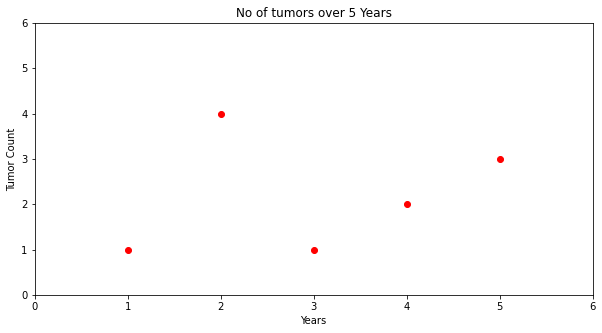

In [34]:
pid = 1.0
pdata = patients_data.loc[patients_data['patient_id'] == pid]
no_of_tumors = pdata['num_of_tumor']
plt.figure(figsize=(10,5))
plt.title('No of tumors over 5 Years')
plt.xlabel('Years')
plt.ylabel('Tumor Count')
plt.plot([1, 2, 3, 4, 5], no_of_tumors, 'ro')
plt.axis([0, 6, 0, 6])
# plt.hist(no_of_tumors)


(0.0, 6.0, 0.0, 100000.0)

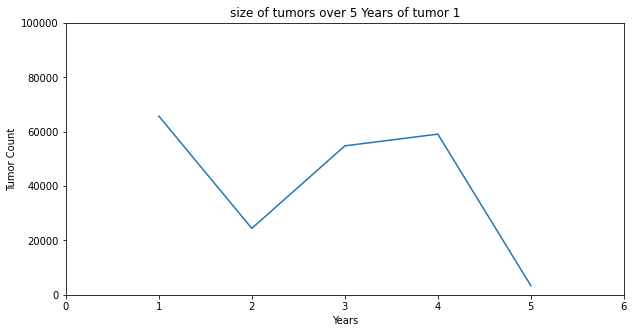

In [35]:
pid = 1.0
pdata = patients_data.loc[patients_data['patient_id'] == pid]
sizes = pdata['size']
plt.figure(figsize=(10,5))
plt.title('size of tumors over 5 Years of tumor 1')
plt.xlabel('Years')
plt.ylabel('Tumor Count')
size = []
for i in range(0,5):
    if no_of_tumors[i] > 1:
        size.append(float(sizes[i].split(',')[0]))
    else:
        size.append(float(sizes[i]))
size
# sizes
plt.plot([1, 2, 3, 4, 5], size)
plt.axis([0, 6, 0, 100000])

(0.0, 6.0, 0.0, 100000.0)

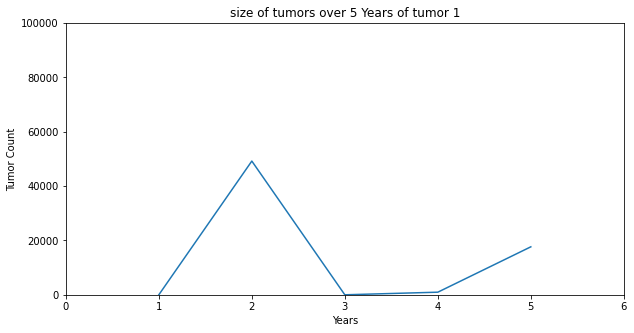

In [40]:
pid = 1.0
pdata = patients_data.loc[patients_data['patient_id'] == pid]
sizes = pdata['size']
plt.figure(figsize=(10,5))
plt.title('size of tumors over 5 Years of tumor 1')
plt.xlabel('Years')
plt.ylabel('Tumor Count')
size = []
for i in range(0,5):
    if no_of_tumors[i] > 1:
        size.append(float(sizes[i].split(',')[1]))
    else:
        size.append(0.0)
size
# sizes
plt.plot([1, 2, 3, 4, 5], size)
plt.axis([0, 6, 0, 100000])